# Bayesian model

In [1]:
import os
os.environ['PYTENSOR_FLAGS'] = 'blas_ldflags='

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import pymc as pm
import arviz as az
from graphviz import Digraph

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pytensor/configparser.py:316: UserWarning: PyTensor does not recognise this flag: blas_ldflags
  warnings.warn(f"PyTensor does not recognise this flag: {key}")


In [2]:
filepath = '../../../../data/processed/df_filtered_5years.xlsx'
df = pd.read_excel(filepath).drop(columns='special')
df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()
df['log_income'] = np.log(df['income'])
df.dropna(inplace=True)

# 四分位範囲（IQR）を計算
Q1 = df['population_change_rate'].quantile(0.25)
Q3 = df['population_change_rate'].quantile(0.75)
IQR = Q3 - Q1

# 外れ値の定義
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 外れ値を除外
df_filtered = df[(df['population_change_rate'] >= lower_bound) & (df['population_change_rate'] <= upper_bound)]

/tmp/ipykernel_3185/332922789.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()


In [3]:
population_change_rate = df_filtered['population_change_rate'].values
bridge = df_filtered['dummy_after_bridge_opened'].values
income = np.log(df_filtered['income'].values)

with pm.Model() as model:
    # Priors
    intercept = pm.Normal('intercept', mu=-0.0580, sigma=100)  # 人口は0以上だから
    beta_bridge = pm.Normal('beta_bridge', mu=0.0165, sigma=100)
    beta_income = pm.Normal('beta_income', mu=-0.0110, sigma=100)
    sigma = pm.HalfCauchy('sigma', beta=100)

    # linear model
    mu = intercept + beta_bridge * bridge + beta_income * income

    # Likelihood
    population_change_rate_obs = pm.Normal('population_change_rate_obs', mu=mu, sigma=sigma, observed=population_change_rate)

# モデルの視覚化
graph = pm.model_to_graphviz(model)
graph.render(filename='../../../visualization/graphviz/bm_population_change_rate', format='png', cleanup=True)

'../../../visualization/graphviz/bm_population_change_rate.png'

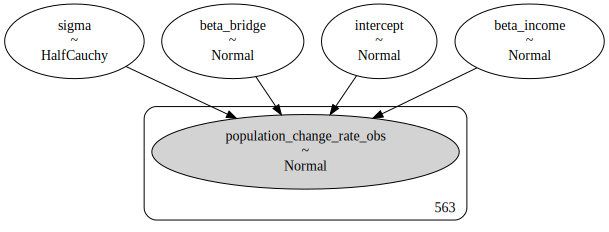

In [35]:
graph

In [32]:
with model:
    idata = pm.sample(
        draws=2000,
        tune=1000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

## アウトプットの保存

In [37]:
az.to_netcdf(idata, 'bm_population_change_rate.nc')

'bm_population_change_rate.nc'

## アウトプットのエクスポート

In [15]:
idata = az.from_netcdf('bm_population_change_rate.nc')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.058,0.023,-0.100,-0.014,0.0,0.0,3822.0,3748.0,1.0
beta_bridge,0.017,0.010,-0.002,0.037,0.0,0.0,4975.0,4560.0,1.0
beta_income,-0.011,0.003,-0.016,-0.006,0.0,0.0,3875.0,4004.0,1.0
sigma,0.105,0.003,0.099,0.111,0.0,0.0,4923.0,4348.0,1.0


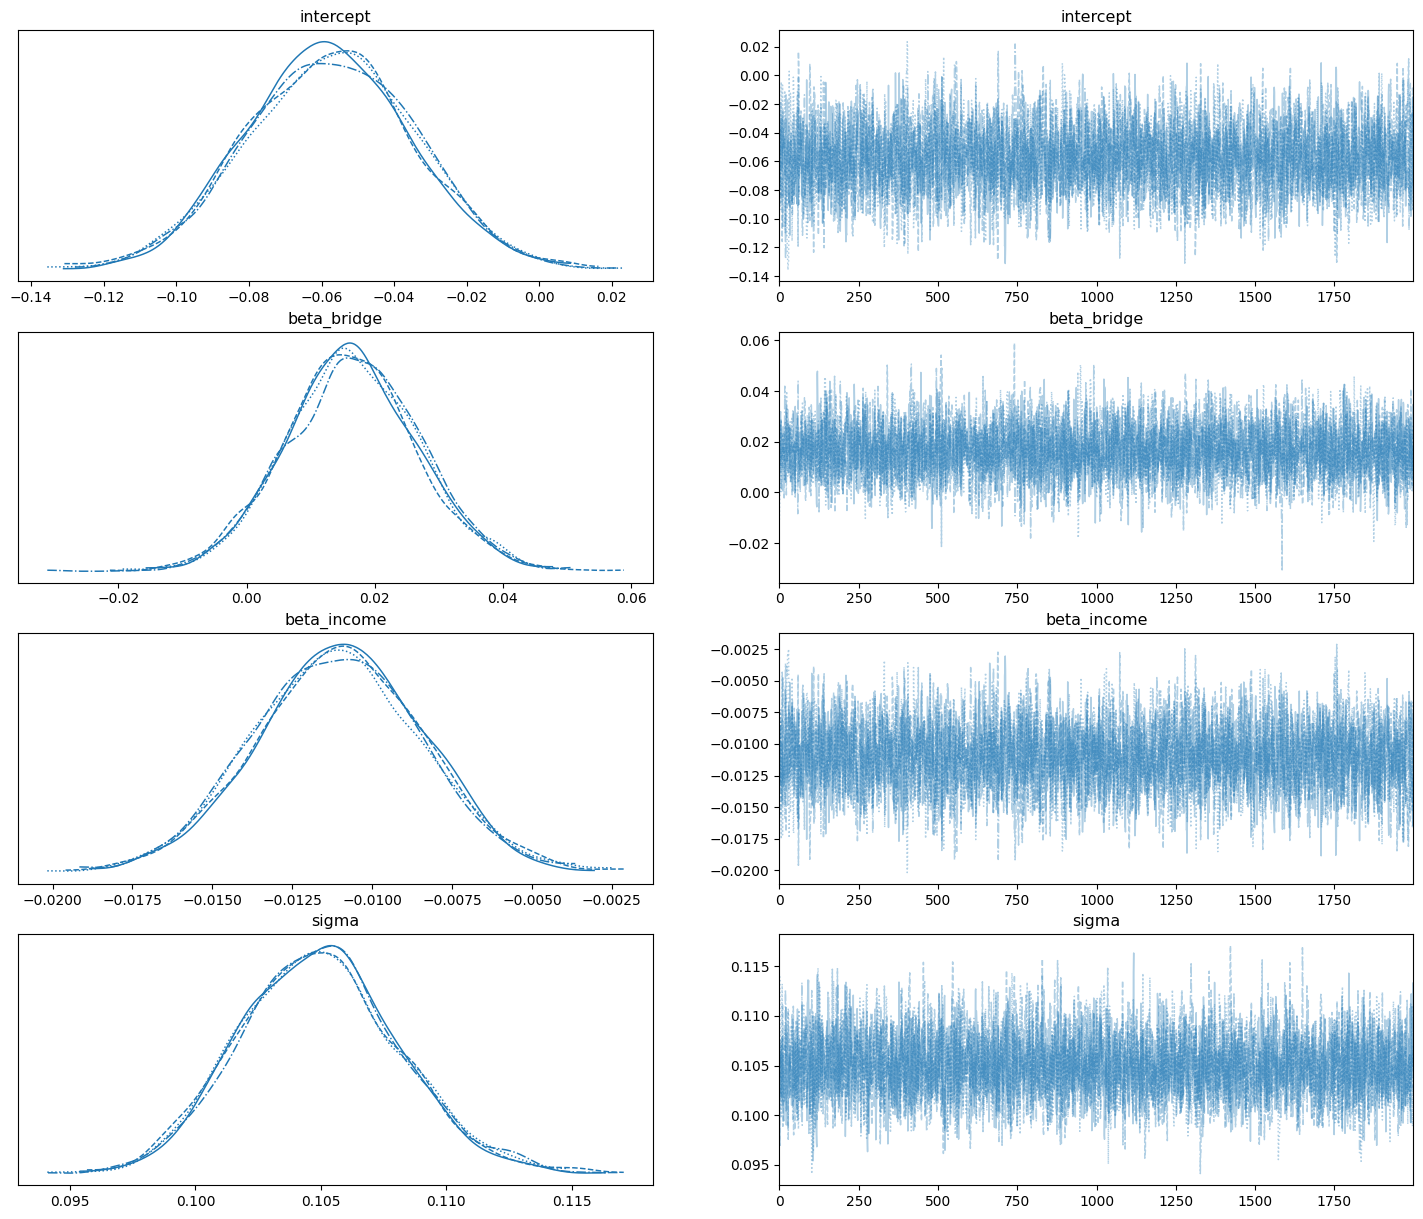

In [33]:
az.plot_trace(idata, figsize=(18, 15))  # サイズを調整
az.summary(idata)

In [40]:
posterior_samples = idata.posterior

beta_bridge_samples = posterior_samples['beta_bridge']

# 0以上のサンプルの割合を計算
prob_intercept_positive = np.mean(posterior_samples['intercept'] > 0)
print(f"Pr(intercept > 0) = {prob_intercept_positive:.4f}")
prob_beta_bridge_positive = np.mean(beta_bridge_samples > 0)
print(f"Pr(beta_bridge > 0) = {prob_beta_bridge_positive:.4f}")
prob_beta_income_positive = np.mean(posterior_samples['beta_income'] > 0)
print(f"Pr(beta_income > 0) = {prob_beta_income_positive:.4f}")
prob_sigma_positive = np.mean(posterior_samples['sigma'] > 0)
print(f"Pr(sigma > 0) = {prob_sigma_positive:.4f}")

Pr(intercept > 0) = 0.0064
Pr(beta_bridge > 0) = 0.9463
Pr(beta_income > 0) = 0.0000
Pr(sigma > 0) = 1.0000
